# Import the pandas, numpy, matplotlib, seaborn, lightgbm, and sklearn libraries

In [2]:
## Clear the environment!
import sys
import os

abpath = os.path.abspath("pitchpredictions.ipynb")
print(abpath)

import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import class_weight

from random import sample

C:\Users\Erik\Desktop\Programming\Python\WinPython-64bit-3.6.1.0Qt5\notebooks\docs\Swish\pitchpredictions.ipynb


 I've never used a **gradient-boosted machine** or a **naive Bayes classifier**, and was crazy enough to take a risk and try it:
   it's a large, multi-class classification task with a strong motivation for speed and not necessarily
   accuracy. I explored the data, using my background knowledge of the game to manually investigate features
   (how many `pitches`? what `types`? how many `games`, `pitchers`, `hitters`, `years`, etc.) first.
   I then checked my assumptions/suspicions with feature importance.
   
   **I condensed a group of features I thought might be powerful** (runners on which bases and how many outs)
   to speed up computation/fit time. This variable in baseball analytics is used to derive "leverage" (game situation value; **RE24**).
   Having runners on base can significantly effect the pitch choices, and especially when integrated with the outs and score.
   Yet, I surprisingly found this was extremely unimportant, and obviously computationally costly, but I kept the
   (inefficient) code to demonstrate thought process.
    
   **I then focused on cutting all my features down** to the smallest of `pitcher_id`, `batter_id`, and `score`, which I broke down as
   categorical data. I compared using `gridsearch` as cross-validation, optimizing one parameter
   (a regularization term) to a non-cross-validated, nor hyperparameter-optimized `GBM` to address overfitting, as is likely in this scenario.
   **I contrasted speed/accuracy across models**. In real time, I recognize a gridsearch approach won't be viable pitch-to-pitch to re-fit,
   or even between innings, but if the model could be built offline and tested for game(s) each day, it might be more informative.
    
   **Since this is multi-class classification, I measured accuracy with a confusion matrix, precision, recall, and F1.**
   Ultimately, **the CV bgm and naive Bayes classifier performed similarly**. Given the extra computation time for gridsearching and CV,
   **I opted for** a slightly less precise model with comparable accuracy (**naive Bayes**), also factoring in that the model delivered the most similar
   distribution of pitch types-- not 80-90% predicted fastballs.

# Import data and data prep

In [4]:
# Import the data from a relevant filepath

PITCHES = pd.read_csv('C:/Users/Erik/Desktop/Programming/Python/WinPython-64bit-3.6.1.0Qt5/notebooks/docs/Swish/pitches',
                       index_col = 0,
                       comment = ";",
                       low_memory = False)

PITCHES = pd.DataFrame(PITCHES)

    ## Check out the pitch types
PITCHES['pitch_type'].unique().tolist()
len(PITCHES['pitch_type'].unique().tolist()) ## Some unknown pitch types, even by MLBAM categories
    ## Check out pitcher and hitter/batter id's
len(PITCHES['batter_id'].unique().tolist()) ## roughly an entire season's worth of unique hitters
len(PITCHES['pitcher_id'].unique().tolist()) ## roughly an entire season's worth of unique pitchers

    ## How many are nan?
len(PITCHES.loc[PITCHES['pitch_type'].isnull(), 'pitch_type'])
    ## 2280.. surprisingly a lot.
    
    ## Remove excess data; manual feature selection, and remove nan pitch_types:
        ## pcount_pitcher, pcount_at_bat, final_pitch, balls, strikes, outs, inning, batter_id, stand,
        ## pitcher_id, p_throws, away_team_runs, home_team_runs, on_1b, on_2b, on_3b, pitch_type
PITCHES_subset = PITCHES.loc[PITCHES['pitch_type'].notnull(),
                             ['inning', 'pcount_pitcher', 'balls', 'strikes', 'outs',
                                  'stand', 'p_throws',
                                  'away_team_runs', 'home_team_runs',
                                  'on_1b', 'on_2b', 'on_3b', 'pitch_type']
                             ]
    ## Create a list of the pitch types
pitch_type_list = PITCHES_subset['pitch_type'].unique().tolist()

    ## Loop over the list and create a column of integer encoded values to examine the freq dist. of the pitch types
for i in range(len(pitch_type_list)):
    PITCHES_subset.loc[ PITCHES_subset['pitch_type'] == pitch_type_list[i], 'pitch_type_int'] = i+1
    ## Create a corresponding integer-encoded list of those pitch_type values/integers
pitch_type_list_int = [i+1 for i in range(len(pitch_type_list))]

# Eval the distributions of the data

In [14]:
-

C:\Users\Erik\Desktop\Programming\Python\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\matplotlib\cbook.py:2216: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Erik\Desktop\Programming\Python\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Erik\Desktop\Programming\Python\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\matplotlib\axes\_base.py:252: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.new

FF : 238541
SL : 109756
CU : 56379
SI : 87740
FC : 41702
FT : 81056
KC : 8490
CH : 72641
IN : 4058
KN : 4450
FS : 10503
FA : 204
PO : 559
FO : 329
EP : 134
UN : 17
SC : 120

C:\Users\Erik\Desktop\Programming\Python\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)



AB : 2


In [15]:
## Derive new column, 'baseout_state' (aka RE24), that integrates how many runners on, where, and how many outs:
    ## 0 outs
        ## empty = 0, 1b = 1, 2b = 2, 3b = 3, 1b & 2b = 4, 1b & 3b = 5, 2b & 3b = 6, loaded = 7
    ## 1 out
        ## empty = 8, 1b = 9, 2b = 10, 3b = 11, 1b & 2b = 12, 1b & 3b = 13, 2b & 3b = 14, loaded = 15
    ## 2 outs
        ## empty = 16, 1b = 17, 2b = 18, 3b = 19, 1b & 2b = 20, 1b & 3b = 21, 2b & 3b = 22, loaded = 23

In [16]:
PITCHES_subset = PITCHES_subset.assign(baseout_state = 0)

In [17]:
## Fill
    ## 0 outs
        ## 1b only
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].notnull()) &
                (PITCHES_subset['on_2b'].isnull()) &
                (PITCHES_subset['on_3b'].isnull()) &
                (PITCHES_subset['outs'] == 0)] = 1
        ## 2b only
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].isnull()) &
                (PITCHES_subset['on_2b'].notnull()) &
                (PITCHES_subset['on_3b'].isnull()) &
                (PITCHES_subset['outs'] == 0)] = 2
        ## 3b only
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].isnull()) &
                (PITCHES_subset['on_2b'].isnull()) &
                (PITCHES_subset['on_3b'].notnull()) &
                (PITCHES_subset['outs'] == 0)] = 3
        ## 1b & 2b
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].notnull()) &
                (PITCHES_subset['on_2b'].notnull()) &
                (PITCHES_subset['on_3b'].isnull()) &
                (PITCHES_subset['outs'] == 0)] = 4
        ## 1b & 3b
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].notnull()) &
                (PITCHES_subset['on_2b'].isnull()) &
                (PITCHES_subset['on_3b'].notnull()) &
                (PITCHES_subset['outs'] == 0)] = 5
        ## 2b & 3b
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].isnull()) &
                (PITCHES_subset['on_2b'].notnull()) &
                (PITCHES_subset['on_3b'].notnull()) &
                (PITCHES_subset['outs'] == 0)] = 6
        ## Loaded
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].notnull()) &
                (PITCHES_subset['on_2b'].notnull()) &
                (PITCHES_subset['on_3b'].notnull()) &
                (PITCHES_subset['outs'] == 0)] = 7

    ## 1 out
        ## empty
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].isnull()) &
                (PITCHES_subset['on_2b'].isnull()) &
                (PITCHES_subset['on_3b'].isnull()) &
                (PITCHES_subset['outs'] == 1)] = 8
        ## 1b only
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].notnull()) &
                (PITCHES_subset['on_2b'].isnull()) &
                (PITCHES_subset['on_3b'].isnull()) &
                (PITCHES_subset['outs'] == 1)] = 9
        ## 2b only
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].isnull()) &
                (PITCHES_subset['on_2b'].notnull()) &
                (PITCHES_subset['on_3b'].isnull()) &
                (PITCHES_subset['outs'] == 1)] = 10
        ## 3b only
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].isnull()) &
                (PITCHES_subset['on_2b'].isnull()) &
                (PITCHES_subset['on_3b'].notnull()) &
                (PITCHES_subset['outs'] == 1)] = 11
        ## 1b & 2b
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].notnull()) &
                (PITCHES_subset['on_2b'].notnull()) &
                (PITCHES_subset['on_3b'].isnull()) &
                (PITCHES_subset['outs'] == 1)] = 12
        ## 1b & 3b
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].notnull()) &
                (PITCHES_subset['on_2b'].isnull()) &
                (PITCHES_subset['on_3b'].notnull()) &
                (PITCHES_subset['outs'] == 1)] = 13
        ## 2b & 3b
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].isnull()) &
                (PITCHES_subset['on_2b'].notnull()) &
                (PITCHES_subset['on_3b'].notnull()) &
                (PITCHES_subset['outs'] == 1)] = 14
        ## Loaded
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].notnull()) &
                (PITCHES_subset['on_2b'].notnull()) &
                (PITCHES_subset['on_3b'].notnull()) &
                (PITCHES_subset['outs'] == 1)] = 15
                                 
    ## 2 outs
        ## empty
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].isnull()) &
                (PITCHES_subset['on_2b'].isnull()) &
                (PITCHES_subset['on_3b'].isnull()) &
                (PITCHES_subset['outs'] == 2)] = 16
        ## 1b only
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].notnull()) &
                (PITCHES_subset['on_2b'].isnull()) &
                (PITCHES_subset['on_3b'].isnull()) &
                (PITCHES_subset['outs'] == 2)] = 17
        ## 2b only
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].isnull()) &
                (PITCHES_subset['on_2b'].notnull()) &
                (PITCHES_subset['on_3b'].isnull()) &
                (PITCHES_subset['outs'] == 2)] = 18
        ## 3b only
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].isnull()) &
                (PITCHES_subset['on_2b'].isnull()) &
                (PITCHES_subset['on_3b'].notnull()) &
                (PITCHES_subset['outs'] == 2)] = 19
        ## 1b & 2b
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].notnull()) &
                (PITCHES_subset['on_2b'].notnull()) &
                (PITCHES_subset['on_3b'].isnull()) &
                (PITCHES_subset['outs'] == 2)] = 20
        ## 1b & 3b
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].notnull()) &
                (PITCHES_subset['on_2b'].isnull()) &
                (PITCHES_subset['on_3b'].notnull()) &
                (PITCHES_subset['outs'] == 2)] = 21
        ## 2b & 3b
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].isnull()) &
                (PITCHES_subset['on_2b'].notnull()) &
                (PITCHES_subset['on_3b'].notnull()) &
                (PITCHES_subset['outs'] == 2)] = 22
        ## Loaded
PITCHES_subset['baseout_state'].loc[(PITCHES_subset['on_1b'].notnull()) &
                (PITCHES_subset['on_2b'].notnull()) &
                (PITCHES_subset['on_3b'].notnull()) &
                (PITCHES_subset['outs'] == 2)] = 23

C:\Users\Erik\Desktop\Programming\Python\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Erik\Desktop\Programming\Python\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Erik\Desktop\Programming\Python\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to 

In [18]:
    ## Convert 'baseout_state' column to categorical data.
        ## This integrates both 'outs' and 'base_states' and reduces the computation required to integrate categorical runner ID's
            ## Runners being on base is important in dictating pitch types, particularly relative to inning
                ## and score
PITCHES_subset['baseout_state'] = PITCHES_subset['baseout_state'].astype('category')

    ## Replace categorical values with integers; batter and pitcher handedness should have
        ## a strong impact on pitch type
PITCHES_subset['p_throws'] = PITCHES_subset['p_throws'].astype('category')
PITCHES_subset['stand'] = PITCHES_subset['p_throws'].astype('category')

In [19]:
    ## Create dummy variables for handednesses
FIRST = pd.get_dummies(PITCHES_subset, columns = ['p_throws', 'stand'],
                     drop_first = True)
    ## Re-order
FIRST = FIRST[['inning', 'pcount_pitcher', 'balls', 'strikes', 'outs',
                                  'stand_R', 'p_throws_R',
                                  'away_team_runs', 'home_team_runs', 'baseout_state',
                                  'pitch_type', ]]
    ## Create dummy variables for baseout_state and pitch_type
FIRST = pd.get_dummies(FIRST, columns = ['baseout_state'], drop_first = False)

In [20]:
    ## Split the data for fitting and eval; use a larger test size to speed computation/fitting and
        ##to prevent overfitting
X_train, X_test, y_train, y_test = train_test_split(FIRST.loc[:, FIRST.columns != 'pitch_type'],
                                                    FIRST.loc[:, 'pitch_type' ].astype('object'),
                                                    test_size = 0.25)

# Train a gradient-boosted machine (tree)
# Use KFold cross-validation (because of data size) to test.
Get a feel for which features are important; probably too dense for `SVM`

Feature: 0, Score: 5411.00000
Feature: 1, Score: 10181.00000
Feature: 2, Score: 3739.00000
Feature: 3, Score: 3060.00000
Feature: 4, Score: 917.00000
Feature: 5, Score: 1605.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 5267.00000
Feature: 8, Score: 4270.00000
Feature: 9, Score: 724.00000
Feature: 10, Score: 255.00000
Feature: 11, Score: 112.00000
Feature: 12, Score: 24.00000
Feature: 13, Score: 65.00000
Feature: 14, Score: 24.00000
Feature: 15, Score: 31.00000
Feature: 16, Score: 20.00000
Feature: 17, Score: 373.00000
Feature: 18, Score: 332.00000
Feature: 19, Score: 158.00000
Feature: 20, Score: 119.00000
Feature: 21, Score: 105.00000
Feature: 22, Score: 53.00000
Feature: 23, Score: 114.00000
Feature: 24, Score: 58.00000
Feature: 25, Score: 358.00000
Feature: 26, Score: 258.00000
Feature: 27, Score: 247.00000
Feature: 28, Score: 669.00000
Feature: 29, Score: 144.00000
Feature: 30, Score: 56.00000
Feature: 31, Score: 171.00000
Feature: 32, Score: 80.00000


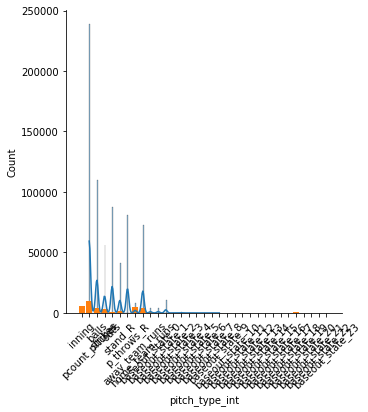

In [21]:
model_Boost = LGBMClassifier()
    ## Fit the model
unopt_Boostfit = model_Boost.fit(X_train, y_train) ## Takes ~ 15s 
    ## (less than time between pitches in an MLB game)

unopt_importance = unopt_Boostfit.feature_importances_
unopt_importance_feature_names = unopt_Boostfit.feature_name_

for i,v in enumerate(unopt_importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
unopt_importance_feature_names
plt.bar([x for x in range(len(unopt_importance))], unopt_importance)
plt.xticks(range(len(unopt_importance_feature_names)), unopt_importance_feature_names[:], rotation = 45)
plt.show()

In [22]:
accuracy_score(y_test, unopt_Boostfit.predict(X_test))

0.31274034302426174

In [23]:
preds = pd.DataFrame({'pred_class' : unopt_Boostfit.predict(X_test)})
pred_probs = unopt_Boostfit.predict_proba(X_test)
pred_probs = pd.DataFrame(pred_probs)
pred_probs.columns = [pitch_type_list]

preds.groupby('pred_class').size() / len(preds) * 100

pred_class
CH        1.729633
CU        0.883514
FC        0.851142
FF       88.109125
FS        0.159066
FT        1.639774
IN        0.618962
KC        0.188647
KN        0.152368
OTHER     0.144555
SI        1.595682
SL        3.907999
UN        0.019534
dtype: float64

In [24]:
del preds, pred_probs, model_Boost, unopt_Boostfit

**Predicted fastballs in 82% of cases** when trained on 3/4 the data
     with a **30% accuracy** (not the best model evaluation measure).
     
Suggests a skew, suggests overfit and likely influenced
    by an uneven distribution of labels/events/categories and
    unscalable variables also likely key contributors

Use different features: **not baseout states, balls/strikes/outs, handedness, or inning, or counted data**.
Try to **reduce features as much as possible**: `score`, `game_pk`, `pitcher_id`, `batter_id`.
    
Also **consider a naive Bayes classifier**; OneVsRest `SVM` is too costly

Re-examine; **use fewer, different variables**

In [25]:
SECOND = PITCHES.loc[PITCHES['pitch_type'].notnull(),
                     ['pitcher_id', 'away_team_runs', 'home_team_runs', 'pitch_type']]

    ## Lump the data together; reclassify as "OTHER"
SECOND['pitch_type'].loc[
        (SECOND['pitch_type'] == 'AB') | 
        (SECOND['pitch_type'] == 'FA') | 
        (SECOND['pitch_type'] == 'PO') |
        (SECOND['pitch_type'] == 'FO') |
        (SECOND['pitch_type'] == 'EP') |
        (SECOND['pitch_type'] == 'SC')] = 'OTHER' 

     ## Create a list of the pitch types
pitch_type_list = SECOND['pitch_type'].unique().tolist()

    ## Loop over the list and create a column of integer encoded values to examine the freq dist. of the pitch types
for i in range(len(pitch_type_list)):
    SECOND.loc[ SECOND['pitch_type'] == pitch_type_list[i], 'pitch_type_int'] = i+1
    ## Create a corresponding integer-encoded list of those pitch_type values/integers
pitch_type_list_int = [i+1 for i in range(len(pitch_type_list))]

C:\Users\Erik\Desktop\Programming\Python\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [26]:
    ## Replace categorical values with integers
SECOND['pitcher_id'] = SECOND['pitcher_id'].astype('category')
    ## Re-arrange for convenient indexing
SECOND = SECOND.loc[:, ['pitch_type', 'pitch_type_int', 'home_team_runs', 'away_team_runs', 'pitcher_id']]

    ## Create dummy variables for pitcher_id
SECOND = pd.get_dummies(SECOND, columns = ['pitcher_id'])

In [27]:
    ## Split the data for fitting and eval
X_train, X_test, y_train, y_test = train_test_split(SECOND.iloc[:, 2:],
                                                    SECOND.loc[:, 'pitch_type' ].astype('object'),
                                                    test_size = 0.40)

 Compare three models:
     
     an un-crossvalidated gbm
     a gridsearch KFold bgm model 
     a naive Bayes model

In [ ]:
model_Boost = LGBMClassifier()
model_BoostCV = LGBMClassifier()
model_CNB = ComplementNB()
KF = KFold(n_splits = 5)

    ## Optimize boost_model regularization parameter to prevent overfitting
        ## and counteract the smaller training data set
BoostModel_optimized_params = [{'reg_alpha': [0, 1, 5]
                                }]

clf_Boost_KFold = GridSearchCV(model_BoostCV, param_grid = BoostModel_optimized_params,
                               cv = KF, n_jobs = 1, verbose = 1)

In [ ]:
    ## Partition some of the data for gridsearch
Griddata = sample(list(range(SECOND.shape[0])), round(len(SECOND)*.9))
Gridtestdata = list(set(range(SECOND.shape[0])).difference(Griddata))

    ## Fit the model to optimize regularization parameter; ~ 6 min
BoostCVfit = clf_Boost_KFold.fit(SECOND.iloc[Griddata,2:],
                        SECOND.iloc[Griddata,0])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
    ## Best score?
BoostCVfit.best_score_
    ## Optimal reg.?
BoostCVfit.best_params_ # Use for BestBoost

In [ ]:
    ## Fit all models
model_CV = LGBMClassifier(reg_alpha = 1)
    ## "Optimized" BoostedGradientMachine; has already been trained to optimize hyperparameters
        ## hence, the partition
model_CV.fit(SECOND.iloc[Gridtestdata,2:], SECOND.iloc[Gridtestdata,0])

In [ ]:
    ## "Un-optimized BoostedGradientMachine
model_Boost.fit(X_train, y_train)

In [ ]:
    ## Naive Bayes Complement Classifier
model_CNB.fit(X_train, y_train)

# Collect the predictions and predicted probabilities for evaluation

In [ ]:
   ## CV GBM model
CV_preds = pd.DataFrame({'pred_class':
    model_CV.fit(SECOND.iloc[Gridtestdata,2:],
                        SECOND.iloc[Gridtestdata,0]).predict(X_test)})

In [ ]:
CV_pred_probs = model_CV.predict_proba(X_test)
CV_pred_probs = pd.DataFrame(CV_pred_probs)

In [ ]:
    ## Un cross-validated GBM model
Boost_preds = pd.DataFrame({'pred_class':
    model_Boost.fit(X_train, y_train).predict(X_test)})

In [ ]:
Boost_pred_probs = model_Boost.fit(X_train, y_train).predict_proba(X_test)
Boost_pred_probs = pd.DataFrame(Boost_pred_probs)

In [ ]:
    ## Naive Bayes model
Bayes_preds = pd.DataFrame({'pred_class':
    model_CNB.fit(X_train, y_train).predict(X_test)})

In [ ]:
Bayes_pred_probs = model_CNB.fit(X_train, y_train).predict_proba(X_test)
Bayes_pred_probs = pd.DataFrame(Bayes_pred_probs)

In [ ]:
    ## Accuracy scores don't mean on their own for multi-class classifications, but may be useful
accuracy_score(y_test, model_Boost.fit(X_train, y_train).predict(X_test))

In [ ]:
accuracy_score(y_test, model_CV.fit(SECOND.iloc[Gridtestdata,2:],
                                           SECOND.iloc[Gridtestdata,0]).predict(X_test))

In [ ]:
accuracy_score(y_test, model_CNB.fit(X_train, y_train).predict(X_test))

In [ ]:
    ## See if balancing the observations improves model performance
class_weight = class_weight.compute_class_weight('balanced', 
                                                 SECOND.iloc[Gridtestdata,0].unique(),
                                                 SECOND.iloc[Gridtestdata,0])    
    ## Use in CV GBM model
model_CV.fit(X_train, y_train, eval_class_weight = class_weight, verbose = 1)

In [ ]:
    ## Does model improve accuracy?
accuracy_score(y_test, model_CV.fit(SECOND.iloc[Gridtestdata,2:],
                                           SECOND.iloc[Gridtestdata,0],
                                           eval_class_weight = class_weight).predict(X_test)) ## Not at all

In [ ]:
    ## What do the predictions look like?
Boost_preds.groupby(['pred_class']).size() / len(Boost_preds) * 100
CV_preds.groupby(['pred_class']).size() / len(CV_preds) *100
Bayes_preds.groupby(['pred_class']).size() / len(Bayes_preds) * 100

# Confusion matrices

In [ ]:
Boost_cnf_matrix = confusion_matrix(y_test, Boost_preds)
CV_cnf_matrix = confusion_matrix(y_test, CV_preds)
Bayes_cnf_matrix = confusion_matrix(y_test, Bayes_preds)

In [ ]:
## Plot Boost (no CV) confusion matrix
norm_conf = []
for i in Boost_cnf_matrix:
    a = 0
    tmp = []
    a = sum(i, 0)
    for j in i:
        tmp.append(float(j)/float(a))
    norm_conf.append(tmp)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = Boost_cnf_matrix.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(Boost_cnf_matrix[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
plt.xticks(range(width), pitch_type_list[:width])
plt.yticks(range(height), pitch_type_list[:height])
plt.title('Gradient-Boosted Machine Classification Confusion Matrix')
plt.show()

In [ ]:
## Plot Boost +CV confusion matrix
norm_conf = []
for i in CV_cnf_matrix:
    a = 0
    tmp = []
    a = sum(i, 0)
    for j in i:
        tmp.append(float(j)/float(a))
    norm_conf.append(tmp)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = CV_cnf_matrix.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(CV_cnf_matrix[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
plt.xticks(range(width), pitch_type_list[:width])
plt.yticks(range(height), pitch_type_list[:height])
plt.title('K-Fold, regularized Gradient-Boosted Machine Classification Confusion Matrix')
plt.show()

In [ ]:
## Plot Boost naive Bayes confusion matrix
norm_conf = []
for i in Bayes_cnf_matrix:
    a = 0
    tmp = []
    a = sum(i, 0)
    for j in i:
        tmp.append(float(j)/float(a))
    norm_conf.append(tmp)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = Bayes_cnf_matrix.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(Bayes_cnf_matrix[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
plt.xticks(range(width), pitch_type_list[:width])
plt.yticks(range(height), pitch_type_list[:height])
plt.title('Naive Bayes Complement Classification Confusion Matrix')
plt.show()

# Precision, Recall, F-scores

In [ ]:
    ## Find precision, recall and f-scores
        ## For the gbm
            ## for each pitch type
Boost_scores_by_pitch = precision_recall_fscore_support(np.array(y_test),
                                Boost_preds)
            ## averaged across all pitch_types
Boost_global_scores = precision_recall_fscore_support(np.array(y_test),
                                Boost_preds, average= 'macro')
        ## For the gridsearch cv gbm
            ## for each pitch type
CV_scores_by_pitch = precision_recall_fscore_support(np.array(y_test),
                                CV_preds)
            ## averaged across all pitch types
CV_global_scores = precision_recall_fscore_support(np.array(y_test),
                                CV_preds, average= 'macro')
        ## For the NB
            ## for each pitch type
Bayes_scores_by_pitch = precision_recall_fscore_support(np.array(y_test),
                                Bayes_preds)
            ## averaged across all pitch types
Bayes_global_scores = precision_recall_fscore_support(np.array(y_test),
                                Bayes_preds, average= 'macro')

In [ ]:
    ## Store in a matrix
Model_Scores_Mat = pd.DataFrame({'GBM': Boost_global_scores[:3], 
                                 'GridsearchCV GBM': CV_global_scores[:3],
                                 'naive Bayes': Bayes_global_scores[:3]}, index = ['precision', 'recall', 'F-score'])

 `CV` is more precise, and accurate, but takes too long to optimize and re-fit.
 `Naive Bayes` is faster, comparably precise and accurate. Model is less biased towards `Sinkers` (SI).

# Extract predicted probabilities from the test data

In [ ]:
    ## Re-name column
Bayes_pred_probs.columns = pitch_type_list
    ## Append actual calls
Bayes_pred_probs  = Bayes_pred_probs.assign(Predicted = Bayes_preds)
    ## --> Calls are not the same as the maximum predicted probability

 Conclusions and Future Directions:
 
With a goal to compare three different alogrithms, the **naive Bayes seemed to offer
comparable performance** (based on confusion matrix with something resembling a diagonal; also
based on the relative frequencies of predicted pitches to those from the original data; on `precision`,
`recall` and `F-score`) without the computation drag. Makes sense: it's supposed to discard rare events,
and many pitches were <= 1% of all pitches. Makes a more generalizable model with predictions that are
more realistic (not just predicting every pitch to be a 4sm fastball (`FF`) ). Also, if given the choice between
two similar-performing models with similar computation time, I'd choose the model that returns more realistic
predictions (not just predicting all 4sm fastballs). 
     
Feature engineering is key, here, and at least as much as choosing the appropriate model.
Reducing dimensions is critical, and dimensionality reduction was another approach I considered.
**With the emphasis on real-time (and deadline constraints), I thought manually stripping down the
variables would suffice**. I took a broad, ambitious route, and I would have liked to explore
learning rate and regularization parameters.
     
Cross-validating/gridseaching quickly enough in a real-time (pitch-to-pitch) setting to re-fit and test models
to derive probabilities is a huge challenge, but I think **one good way to go: building a cross-validated
GBM offline and testing it without re-fitting in real-time** seems like a valid strategy; could be used 
to optimize learning rate and regularization parameters.
     
I did not e.g. create a function that could return pitch type probabilities derived from a model
given the requisite inputs to that model. Obviously, building a model offline and updating it in
real-time is the ideal strategy.
     
The **ultimate goal is crucial**: is this for all games simultaneously (i.e. how general?)?
It matters because I tried to capture categorical variables that should have a strong impact 
on predictions/accuracy: **a pitcher who doesn't throw knuckleballs isn't likely to throw knuckleballs in reality!**
So, when given the choice between features most important to the `pitch type` (`pitcher ID`, `batter ID`, `game`),
I chose the smallest of the three variables for computation speed.
Also, **building pitch type probability models specific to each pitcher** would obviously be an interesting and more accurate goal
than generalizing across all pitchers.